## Harmonic number

If you took some discrete math courses, you have probably seen this sum
$$
\newcommand{\Bold}[1]{\mathbf{#1}}{\sum_{i=1}^{m} \frac{1}{i}}
$$
This is called the $m$-th [Harmonic number](https://en.wikipedia.org/wiki/Harmonic_number) and is often written as $H_m$.

Why should we care? Well, for one thing, if there $10$ different coupons, and the type you can is uniform at random whenever you buy one, then on average you need to buy to get all of them is
$$
\newcommand{\Bold}[1]{\mathbf{#1}}{\sum_{i=0}^{m-1} \frac{m}{m-i}} = m H_{m}
$$
This is the famous [coupon collectors problem](https://en.wikipedia.org/wiki/Coupon_collector%27s_problem) 🎉️.

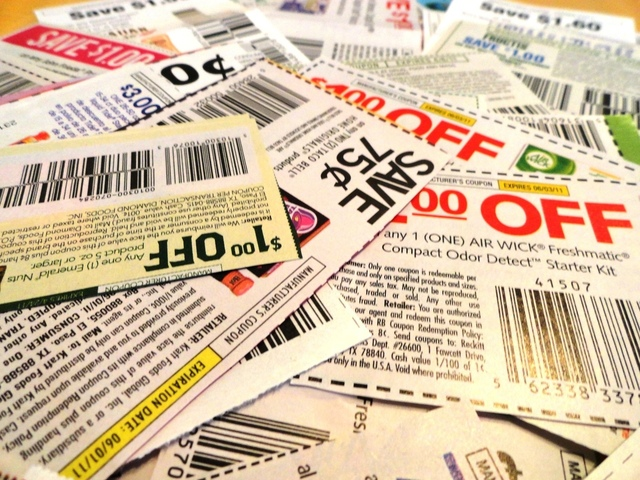
<center>
(Photo by <a href="/photographer/BessieSpin-81413">BessieSpin</a> from <a href="https://freeimages.com/">FreeImages</a>)
</center>

Let's see how we can compute and approximate this in Julia.
But first, Julia is not a CAS (computer algebra system).
But fortunately, we have [`SymPy.jl`](https://github.com/JuliaPy/SymPy.jl).
It allows us to use [`SymPy`](https://www.sympy.org/en/index.html), a CAS written entirely in Python. A good source of learning to use `SymPy.jl` is [Symbolic math with julia](http://mth229.github.io/symbolic.html).

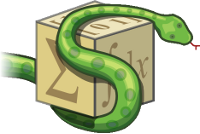

Of course you will need to install Python and `SymPy` itself first. And to run this notebook, you also need to add the following Julia packages.

In [ ]:
using Pkg; 
Pkg.add("SymPy")
Pkg.add("Plots")
Pkg.add("BenchmarkTools")
Pkg.add("LaTeXStrings")
Pkg.add("FastRationals")

In [2]:
using SymPy
@vars i m;
harmonic = summation(1/i, (i, 1, m))

harmonic(m)

What we get here is a symbolic object (representing a math symbol) of type `Sym`

In [3]:
typeof(harmonic)

Sym

To compute $H_m$, we just need to replace $m$ in the expression `harmonic` by a integer.

In [4]:
subs(harmonic, m, 10)

7381
────
2520

But there is a short cut for this substitution. We can use `harmonic` just as if it is a Julia function.

In [5]:
h10 = harmonic(10)

7381
────
2520

The first ten harmonic numbers are

In [6]:
transpose(map(harmonic, 1:10))

1×10 LinearAlgebra.Transpose{Sym,Array{Sym,1}}:
 1  3/2  11/6  25/12  137/60  49/20  363/140  761/280  7129/2520  7381/2520

## The speed

How fast can `SymPy` compute the Harmonic numbers? We can find out with [BenchmarkTools.jl](https://github.com/JuliaCI/BenchmarkTools.jl). 
We load it and use the marco `@benchmark` test how faster can we compute `harmonic(10000)`. The macro runs the computation many times to get an average performance. 
It will take a while. Make a tea 🍵️ for your self. 

In [7]:
using BenchmarkTools

In [8]:
m0 = 10^4
@benchmark harmonic(m0)

BenchmarkTools.Trial: 
  memory estimate:  1.31 KiB
  allocs estimate:  47
  --------------
  minimum time:     94.483 μs (0.00% GC)
  median time:      97.704 μs (0.00% GC)
  mean time:        105.042 μs (0.00% GC)
  maximum time:     23.499 ms (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

As you can see, the longest time it take to compute `harmonic(10^4)` is about 270 times slower than the median time. 
[Jeffery Sarnoff](https://julialang.slack.com/archives/C66NPKCQZ/p1586874541165500?thread_ts=1586872314.165100&cid=C66NPKCQZ) pointed out to me that

> As far as I know, when the `maximum time` reported by `@benchmark` is much larger than the median time (as usually is the case) you are seeing overhead unrelated to the function evaluation itself (e.g. the OS is handling other things).  It is important for realtime systems and mostly irrelevant otherwise.

Though I did check the code of`SymPy` and found that it does some [memoization](https://en.wikipedia.org/wiki/Memoization) here -- After the first time `H_m` is computed, `SymPy` just remembers it. This may also explains the difference.

## Three Julia implementations

Of course you can also do this purely with Julia. Don't forget to use `//` instead of `/`, the first gives rational number, the second gives a float number.

In [9]:
harmonic_j(m) = sum(i->1//big(i), 1:m)

harmonic_j (generic function with 1 method)

In [10]:
harmonic_j(10^4) == harmonic(m0)

true

In [11]:
@benchmark harmonic_j(m0)

BenchmarkTools.Trial: 
  memory estimate:  5.19 MiB
  allocs estimate:  169990
  --------------
  minimum time:     349.699 ms (0.00% GC)
  median time:      369.920 ms (0.00% GC)
  mean time:        379.078 ms (1.67% GC)
  maximum time:     555.587 ms (15.98% GC)
  --------------
  samples:          14
  evals/sample:     1

This is a bit slow.
It turns out that `Rational{BigInt}` is just not. 
But there is a package [`FastRationsl.jl`](https://github.com/JeffreySarnoff/FastRationals.jl) which addresses this problem.

In [12]:
using FastRationals

In [13]:
harmonic_fast(m) = sum(i->FastQBig(1, i), 1:m)

harmonic_fast (generic function with 1 method)

In [14]:
harmonic_fast(m0) == N(harmonic(m0))

true

In [15]:
@benchmark harmonic_fast(m0)

BenchmarkTools.Trial: 
  memory estimate:  3.66 MiB
  allocs estimate:  119995
  --------------
  minimum time:     20.617 ms (0.00% GC)
  median time:      22.180 ms (0.00% GC)
  mean time:        42.780 ms (27.93% GC)
  maximum time:     373.927 ms (64.51% GC)
  --------------
  samples:          120
  evals/sample:     1

Almost 20 times speed up. Not bad. But why don't we try `SymPy`'s idea of memoization?

In [16]:
const harmonic_numbers = Array{FastRational{BigInt}, 1}()
function harmonic_cached(m)
    m1 = length(harmonic_numbers)
    if m <= m1
        return harmonic_numbers[m]
    end
    if m1 > 0
        ret = harmonic_numbers[m1]
    else
        ret = 0
    end
    for i in m1+1:m
        ret += FastQBig(1, i)
        push!(harmonic_numbers, ret)
    end
    return ret
end

harmonic_cached (generic function with 1 method)

Let's make sure we have not made any mistakes

In [17]:
all([harmonic_cached(m) == harmonic_fast(m) for m in 1:100])

true

How fast is this version?

In [18]:
@benchmark harmonic_cached(m0)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     33.303 ns (0.00% GC)
  median time:      35.614 ns (0.00% GC)
  mean time:        35.636 ns (0.00% GC)
  maximum time:     79.539 ns (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     993

As you can, this is 200 times faster! And much much faster than calling `SymPy`.

## Approximations

But for any practical purpose, e.g., you want to buy coupons, we don't really need the exact value of harmonic number. A good approximation is enough.

You probably remember that $H_m \sim \log m$. This is to say that when $m$ is really large, the two numbers are quite close. Let's draw a picture.

In [19]:
using Plots; gr();

We load `LatexString` so we can use LaTeX in the plots.

In [20]:
using LaTeXStrings

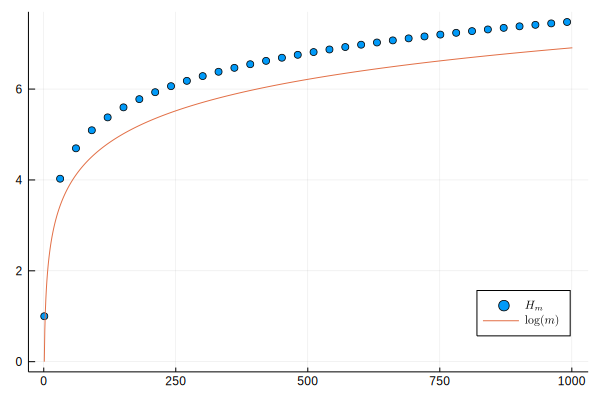

In [21]:
xpos = 1:30:1001;
harmonic_values = map(m->BigFloat(harmonic_cached(m)), xpos);
scatter(xpos, harmonic_values, label=L"H_m", legend=:bottomright)
plot!(log, 1:1001, label=L"\log(m)")

It looks like that $\log(m)$ is indeed close to $H_m$, but there seems to be a gap.

In fact, we can do much better. We [know](https://en.wikipedia.org/wiki/Harmonic_number#Calculation) that
$$
H_m \sim \log m + \gamma + \frac{1}{2 m} - \sum_{k=1}^\infty \frac{B_{2 k}}{2 k m^{2 k}}
$$
where $\gamma$ is [Euler's constant](https://en.wikipedia.org/wiki/Euler%E2%80%93Mascheroni_constant) and $B_{k}$ are [Bernoulli numbers](https://en.wikipedia.org/wiki/Bernoulli_number). (A good way to become immortal is to find a useful constant and people will name it after yourself. 😅)

So the more terms in the above sum, the better approximation we have for $H_m$. Let's try $k=0$ and $k=1$

In [22]:
function harmonic_number_approx(m0, k0)
    approx = log(m0) + sympy.EulerGamma + 1/(2*m0)  
    if k0 >=1 
        approx -= sum([sympy.bernoulli(2*k)/(2*k*m^(2*k)) for k in  1:k0])
    end
    return approx
end

harmonic_number_approx (generic function with 1 method)

In [23]:
harmonic_approx0 = harmonic_number_approx(m, 0)
harmonic_approx0

              1 
log(m) + γ + ───
             2⋅m

In [24]:
harmonic_approx1 = harmonic_number_approx(m, 1)
harmonic_approx1

              1      1  
log(m) + γ + ─── - ─────
             2⋅m       2
                   12⋅m 

Let's see how this works.

In [25]:
approx0_values = map(m->harmonic_approx0(m).evalf(), xpos);
approx1_values = map(m->harmonic_approx1(m).evalf(), xpos);

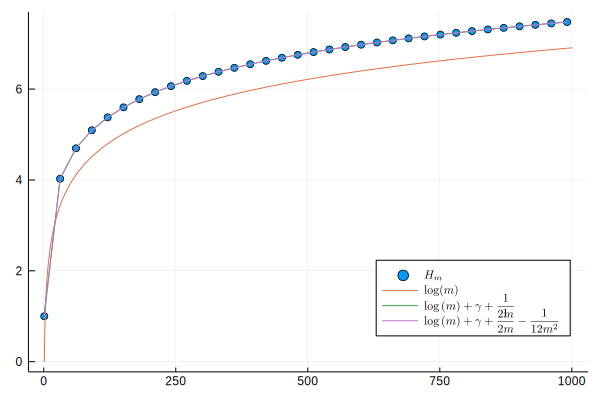

In [26]:
scatter(xpos, harmonic_values, label=L"H_m", legend=:bottomright)
plot!(log, 1:1001, label=L"\log(m)")
plot!(xpos, approx0_values, 1:1001, label=latexstring(sympy.latex(harmonic_approx0)))
plot!(xpos, approx1_values, 1:1001, label=latexstring(sympy.latex(harmonic_approx1)))

The two new apprximations looks much better than $\log(m)$.
But we cannot really tell which of them is better by look at the picture. So let's plot the error instead. To see anything, we have to use log scale plot because the error is so small.

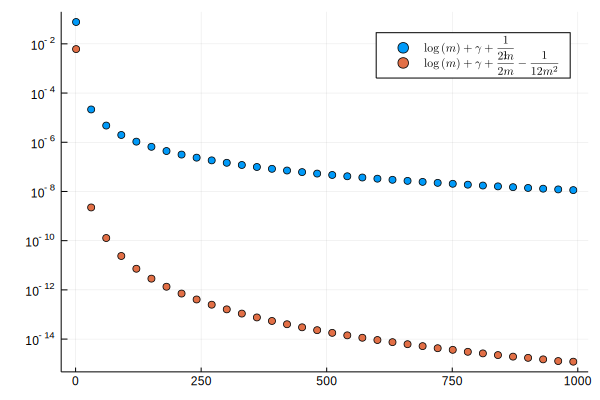

In [27]:
scatter(xpos, abs.((approx0_values./harmonic_values) .- 1), label=latexstring(sympy.latex(harmonic_approx0)), yscale=:log10)
scatter!(xpos, abs.((approx1_values./harmonic_values) .- 1), label=latexstring(sympy.latex(harmonic_approx1)), yscale=:log10)

As you can see the relative error of the second approximation is quite good. So for large $m$ we can safely use it instead of computing the exact value of harmonic numbers. This is much faster! For example, it takes a bit time (2 seconds) to compute

In [28]:
@time harmonic_cached(3*10^4);

  2.333828 seconds (240.00 k allocations: 7.574 MiB)


But for the approximation

In [29]:
@time harmonic_approx1(3*10^4).evalf()

  0.006876 seconds (58 allocations: 1.688 KiB)


10.8861849921199

Life is short. Let's move fast!

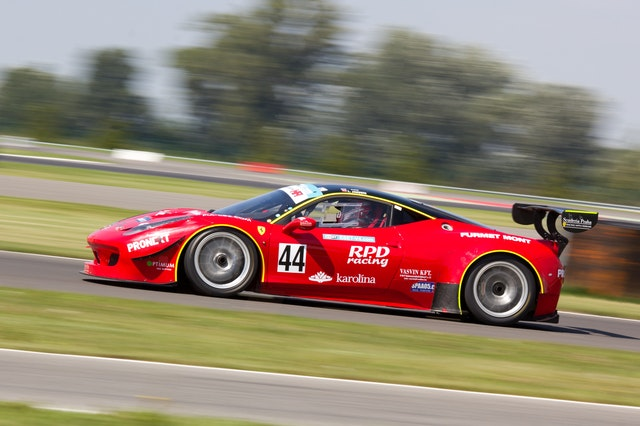
<center>
Photo by Daniel from Pexels
</center>